# 使用TF构建卷积神经网络

感谢大家来我的网站学习https://www.captainbed.net

在这篇notebook文档中，我们将:

- 实现一些工具函数
- 利用这些函数构建一个功能完整的CNN

通过本文档，你将学会使用TensorFlow创建并训练CNN来进行图像分类。

**安装一些工具库**

方法如下
- 从window菜单里打开Anaconda Prompt
- 在里面执行activate tensorflow命令
- 然后在里面执行pip install imageio==2.9.0

开发环境的不同，有时候可能会导致很莫名其妙的问题，所以大家一定要保持与我的开发环境一致。

PS:本次咱们使用Sequential方式来构建模型

首先，还是要加载一些工具库

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras import *
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

运行下面的单元来加载数据集,它里面包含的是0到5的手势。

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

<img src="images/SIGNS.png" style="width:800px;height:300px;">

下面的单元会将数据集里面的某个样本的图片已经它对应的数字打印出来。你可以更改一下index的值，让它打印出不同的样本。

y = 2


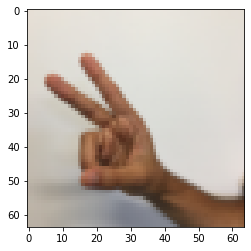

In [3]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

其实在第二章的时候，我们就已经接触了这个数据集。当时我们是在它上面构建了一个全链接神经网络。其实我们应该使用CNN，因为这些数据是图片。就如我们教程中所说的，只要提到智能视觉，那么就应该想到CNN。

下面我们先把这些数据的维度打印出来。因为编程中常常会出现因为维度错乱而导致bug出现。而且一旦出现了还很不好查，所以我们会在很多地方把维度信息打印出来。即可以防止出现维度错乱，又可以在出现bug后帮助定位问题。

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
# tf.one_hot是tensorflow提供的工具函数，可以把输入变成one hot向量
# tf.squeeze是删除大小为1的维度
Y_train = tf.squeeze(tf.one_hot(Y_train_orig, 6))
Y_test = tf.squeeze(tf.one_hot(Y_test_orig, 6))
print ("训练样本数 = " + str(X_train.shape[0]))
print ("测试样本数 = " + str(X_test.shape[0]))
print ("X_train的维度: " + str(X_train.shape))
print ("Y_train的维度: " + str(Y_train.shape))
print ("X_test的维度: " + str(X_test.shape))
print ("Y_test的维度: " + str(Y_test.shape))
conv_layers = {}


训练样本数 = 1080
测试样本数 = 120
X_train的维度: (1080, 64, 64, 3)
Y_train的维度: (1080, 6)
X_test的维度: (120, 64, 64, 3)
Y_test的维度: (120, 6)


Tensorflow 2.x提供了专门用于数据输入的接口tf.data.Dataset，可以简洁高效的实现数据的读入、打乱（shuffle）、增强（augment）等功能。下面我们先以一个简单的实例讲解一下该功能。

In [5]:
#首先手工创建一个非常简单的数据集，该数据包含10个样本，每个样本由1个浮点数组成。
data = np.array([0.1, 0.4, 0.6, 0.2, 0.8, 0.8, 0.4, 0.9, 0.3, 0.2])

#其中大于0.5的样本为正样本，即标签记为1，否则为0。
label = np.array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0])

#然后，可以通过tf.data.Dataset.from_tensor_slices建立数据集。
dataset = tf.data.Dataset.from_tensor_slices((data, label))

#该数据集可以直接由python原生语法进行迭代
for x, y in dataset:
    print('x =', x, 'y =', y)

x = tf.Tensor(0.1, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int32)
x = tf.Tensor(0.4, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int32)
x = tf.Tensor(0.6, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int32)
x = tf.Tensor(0.2, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int32)
x = tf.Tensor(0.8, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int32)
x = tf.Tensor(0.8, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int32)
x = tf.Tensor(0.4, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int32)
x = tf.Tensor(0.9, shape=(), dtype=float64) y = tf.Tensor(1, shape=(), dtype=int32)
x = tf.Tensor(0.3, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int32)
x = tf.Tensor(0.2, shape=(), dtype=float64) y = tf.Tensor(0, shape=(), dtype=int32)


下面我们就用tf.data.Dataset来处理前面从文件里读出的数据。

In [6]:
#将X_train和Y_train打包成一个dataset对象
ds_train = tf.data.Dataset.from_tensor_slices((X_train,Y_train))

# shuffle会在每个epoch都将1080个样本打乱
# batch会将每64个样本打包成一个batch
ds_train = ds_train.shuffle(1080, 1, True).batch(64)

ds_test = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).batch(64)

更多关于from_tensor_slices的知识可以查看官方文档https://tensorflow.google.cn/api_docs/python/tf/data/Dataset?hl=en#from_tensor_slices

同理，所有的函数都有对应的官方文档可以查看的。最权威最完整的解释就是官方文档了！所以同学们一定要养成查官方文档的习惯！

下面我们使用sequential方式来构建一个CNN。

In [7]:
# 因为前面我们导入了keras，所以下面代码相当于cnnmodel = tf.keras.Sequential()
cnnmodel = Sequential()

# 有同学可能发现在《手把手教你从Tensorflow1.x到2.x》中的sequential方式的用法与这里的不同。
# 使用add也是sequential的一种用法！
cnnmodel.add(layers.Input((64,64,3)))

# 添加一个卷积层。指定了8个过滤器。
# 每个过滤器的宽高都是4，深度是3，因为过滤器的深度必须要与输入矩阵相同，所以不需要指定深度。
# 不需要我们自己定义训练参数，框架内部会帮我们处理好
# 参数的初始化方法我们选择了GlorotUniform，并将随机种子设为了1
cnnmodel.add(layers.Conv2D(filters=8,kernel_size=(4, 4),kernel_initializer = initializers.GlorotUniform(1),
                           activation='relu',padding='same'))

# 添加一个最大池化层，池化窗口的宽高都是8，步进也是8
cnnmodel.add(layers.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same'))

cnnmodel.add(layers.Conv2D(filters=16,kernel_size=(2, 2),kernel_initializer = initializers.GlorotUniform(1),
                           activation='relu',padding='same'))

cnnmodel.add(layers.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'))

# 添加一个扁平层，将卷积层扁平化
cnnmodel.add(layers.Flatten())

# 添加一个全连接层，该层有6个神经元，参数也是框架自动生成的，参数的初始化函数为GlorotUniform。激活函数是softmax
cnnmodel.add(layers.Dense(6,kernel_initializer = initializers.GlorotUniform(1), activation='softmax'))

In [8]:
cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
______________________________________________________

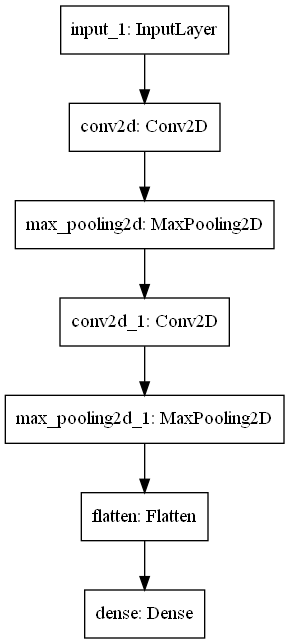

In [9]:
utils.plot_model(cnnmodel, "model.png")

In [10]:
# 编译上面构建的模型。
# 指定adam为优化函数，这个函数里面设置了默认的学习率，当然你也可以修改学习率，详情可以查看官方文档
# 又为其指定了一个成本函数——交叉熵成本函数
cnnmodel.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics='acc')

In [11]:
# 开始训练模型
# 将训练数据ds_train传入。
# epochs=100是指训练100个epoch。
history = cnnmodel.fit(ds_train,epochs=100)

Epoch 1/100
17/17 [==============================] - 3s 138ms/step - loss: 1.8311 - acc: 0.1632
Epoch 2/100
17/17 [==============================] - 2s 140ms/step - loss: 1.7901 - acc: 0.2050
Epoch 3/100
17/17 [==============================] - 2s 138ms/step - loss: 1.7842 - acc: 0.2430
Epoch 4/100
17/17 [==============================] - 2s 140ms/step - loss: 1.7806 - acc: 0.2561
Epoch 5/100
17/17 [==============================] - 2s 139ms/step - loss: 1.7738 - acc: 0.2843
Epoch 6/100
17/17 [==============================] - 3s 144ms/step - loss: 1.7654 - acc: 0.2820
Epoch 7/100
17/17 [==============================] - 2s 140ms/step - loss: 1.7525 - acc: 0.3489
Epoch 8/100
17/17 [==============================] - 3s 144ms/step - loss: 1.7400 - acc: 0.3334
Epoch 9/100
17/17 [==============================] - 2s 138ms/step - loss: 1.7161 - acc: 0.4563
Epoch 10/100
17/17 [==============================] - 3s 158ms/step - loss: 1.6916 - acc: 0.4644
Epoch 11/100
17/17 [===================

17/17 [==============================] - 3s 146ms/step - loss: 0.4577 - acc: 0.8666
Epoch 86/100
17/17 [==============================] - 3s 156ms/step - loss: 0.4634 - acc: 0.8643
Epoch 87/100
17/17 [==============================] - 3s 151ms/step - loss: 0.4460 - acc: 0.8579
Epoch 88/100
17/17 [==============================] - 2s 138ms/step - loss: 0.4342 - acc: 0.8772
Epoch 89/100
17/17 [==============================] - 2s 138ms/step - loss: 0.4475 - acc: 0.8643
Epoch 90/100
17/17 [==============================] - 2s 138ms/step - loss: 0.4185 - acc: 0.8717
Epoch 91/100
17/17 [==============================] - 3s 145ms/step - loss: 0.4220 - acc: 0.8655
Epoch 92/100
17/17 [==============================] - 3s 139ms/step - loss: 0.4252 - acc: 0.8682
Epoch 93/100
17/17 [==============================] - 2s 141ms/step - loss: 0.4076 - acc: 0.8808
Epoch 94/100
17/17 [==============================] - 3s 140ms/step - loss: 0.4052 - acc: 0.8750
Epoch 95/100
17/17 [=======================

可以看到，训练时框架会打印出每个epoch的损失和准确率。最终的准确率为0.8751。当然，通过其它的改进，准确率还会提升。

咱们还可以将上面的历史信息打印成图表

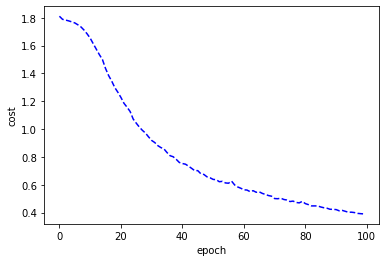

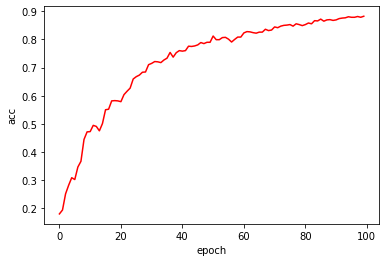

In [12]:
plt.plot(history.history['loss'], 'b--')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['acc'], 'r-')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

In [13]:
# 最后看看在测试集上的损失和准确率是多少
loss, acc = cnnmodel.evaluate(ds_test)
print('loss:', loss, 'acc:', acc)

2/2 [==============================] - 0s 72ms/step - loss: 0.5371 - acc: 0.8250
loss: 0.5370635986328125 acc: 0.824999988079071


恭喜！我们一起构建了一个可以识别手语的CNN程序，识别率达到了86%左右。当然，你还可以继续提升它，通过微调超参数，以及使用我们在第3章中学到的知识来分析优化它。

坚持跟我学到了现在，值得表扬，给你个大拇指！去逛逛pornhub放松放松吧！


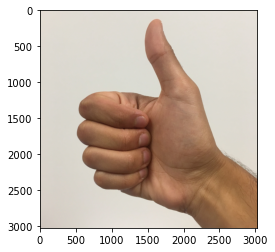

In [14]:
import imageio

fname = "images/thumbs_up.jpg"
image = imageio.imread(fname)

plt.imshow(image)